In [7]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = '/content'

In [8]:
!mkdir datasets

mkdir: cannot create directory ‘datasets’: File exists


In [9]:
!kaggle datasets download -d andrewmvd/liver-tumor-segmentation


100% 4.83G/4.84G [00:43<00:00, 139MB/s]
100% 4.84G/4.84G [00:43<00:00, 120MB/s]


In [10]:
!unzip liver-tumor-segmentation.zip -d dataset

Archive:  liver-tumor-segmentation.zip
  inflating: dataset/segmentations/segmentation-0.nii  
  inflating: dataset/segmentations/segmentation-1.nii  
  inflating: dataset/segmentations/segmentation-10.nii  
  inflating: dataset/segmentations/segmentation-100.nii  
  inflating: dataset/segmentations/segmentation-101.nii  
  inflating: dataset/segmentations/segmentation-102.nii  
  inflating: dataset/segmentations/segmentation-103.nii  
  inflating: dataset/segmentations/segmentation-104.nii  
  inflating: dataset/segmentations/segmentation-105.nii  
  inflating: dataset/segmentations/segmentation-106.nii  
  inflating: dataset/segmentations/segmentation-107.nii  
  inflating: dataset/segmentations/segmentation-108.nii  
  inflating: dataset/segmentations/segmentation-109.nii  
  inflating: dataset/segmentations/segmentation-11.nii  
  inflating: dataset/segmentations/segmentation-110.nii  
  inflating: dataset/segmentations/segmentation-111.nii  
  inflating: dataset/segmentations/segm

In [11]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob
import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image


In [12]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [17]:
file_list = []
for dirname, _, filenames in os.walk("/content/datasets"):
    for filename in filenames:

        file_list.append((dirname,filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

,dirname,filename
41,/content/datasets/segmentations,segmentation-0.nii
15,/content/datasets/segmentations,segmentation-1.nii
4,/content/datasets/segmentations,segmentation-10.nii
92,/content/datasets/segmentations,segmentation-100.nii
86,/content/datasets/segmentations,segmentation-101.nii
...,...,...
160,/content/datasets/volume_pt5,volume-50.nii
144,/content/datasets/volume_pt1,volume-6.nii
141,/content/datasets/volume_pt1,volume-7.nii
146,/content/datasets/volume_pt1,volume-8.nii


In [18]:

df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "/content/datasets/segmentations"

df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
print(len(df_files))
df_files

51


,dirname,filename,mask_dirname,mask_filename
0,/content/datasets/volume_pt1,volume-0.nii,/content/datasets/segmentations,segmentation-0.nii
1,/content/datasets/volume_pt1,volume-1.nii,/content/datasets/segmentations,segmentation-1.nii
2,/content/datasets/volume_pt1,volume-10.nii,/content/datasets/segmentations,segmentation-10.nii
3,/content/datasets/volume_pt2,volume-11.nii,/content/datasets/segmentations,segmentation-11.nii
4,/content/datasets/volume_pt2,volume-12.nii,/content/datasets/segmentations,segmentation-12.nii
5,/content/datasets/volume_pt2,volume-13.nii,/content/datasets/segmentations,segmentation-13.nii
6,/content/datasets/volume_pt2,volume-14.nii,/content/datasets/segmentations,segmentation-14.nii
7,/content/datasets/volume_pt2,volume-15.nii,/content/datasets/segmentations,segmentation-15.nii
8,/content/datasets/volume_pt2,volume-16.nii,/content/datasets/segmentations,segmentation-16.nii
9,/content/datasets/volume_pt2,volume-17.nii,/content/datasets/segmentations,segmentation-17.nii


In [19]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [20]:
sample = 0
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
sample_ct.shape, sample_mask.shape

((512, 512, 75), (512, 512, 75))

In [21]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


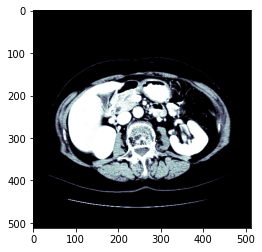

In [22]:

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [23]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
 
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

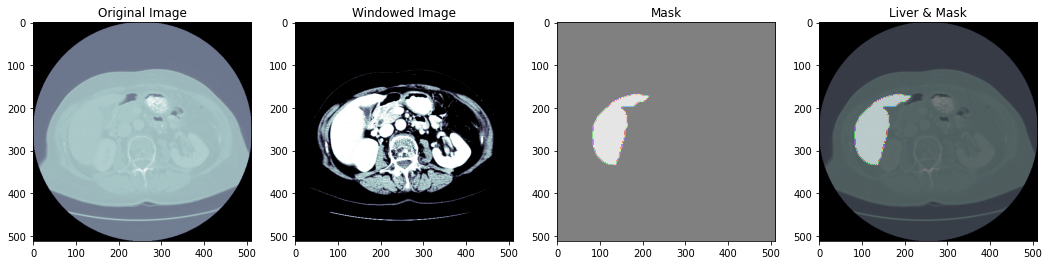

In [24]:
sample=50
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

In [25]:

mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)

[[     0 252049]
 [     1  10095]]


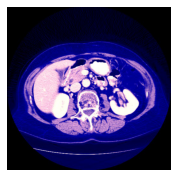

In [26]:

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])


In [ ]:

GENERATE_JPG_FILES = True 

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): 
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii("/content/datasets/segmentations/segmentation-0.nii")
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2]

        for curr_slice in range(0,curr_dim,2):
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,74].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    
    path = Path('/content/datasets/segmentations/liver-segmentation-with-fastai-v2') # read jpg from saved kernel output

  0%|          | 0/17 [00:00<?, ?it/s]

# MODEL TRAINING

In [ ]:
bs = 16
im_size = 128

codes = np.array(["background","liver","tumor"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)), 
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(im_size)],
               get_items=get_image_files,
               get_y=label_func
              )

ds = db.datasets(source=path/'train_images')


In [ ]:
idx=20
imgs = [ds[idx][0],ds[idx][1]]
fig,axs = plt.subplots(1, 2)
for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i]) 

In [ ]:
unique, counts = np.unique(array(ds[idx][1]), return_counts=True)

print( np.array((unique, counts)).T)


In [ ]:
dls = db.dataloaders(path/'train_images',bs = bs) 
dls.show_batch()

In [ ]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean() 

def cust_foreground_acc(inp, targ):  
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) 

In [ ]:
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, cust_foreground_acc]) 

In [ ]:
learn.fine_tune(1, wd=0.1, cbs=SaveModelCallback() )

In [ ]:
learn.show_results()

In [ ]:

learn.export(path/f'Liver_segmentation')

# TESTING MODEL

In [ ]:

if (GENERATE_JPG_FILES) :
    
    tfms = [Resize(im_size), IntToFloatTensor(),Normalize()]
    learn0               = load_learner(path/f'Liver_segmentation',cpu=False )
    learn0.dls.transform = tfms

In [ ]:
def nii_tfm(fn,wins): 

    test_nii  = read_nii(fn)
    curr_dim  = test_nii.shape[2]
    slices = []
    
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[...,curr_slice].astype(np.float32))
        data = (data.to_nchan(wins)*255).byte()
        slices.append(TensorImage(data))
                      
    return slices 

In [ ]:
tst = 20

test_nii   = read_nii(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'])
test_mask  = read_nii(df_files.loc[tst,'mask_dirname']+"/"+df_files.loc[tst,'mask_filename'])
print(test_nii.shape)

test_slice_idx = 500

sample_slice = tensor(test_nii[...,test_slice_idx].astype(np.float32))

plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx]])

In [ ]:

test_files = nii_tfm(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'],[dicom_windows.liver, dicom_windows.custom])
print("Number of test slices: ",len(test_files))

In [ ]:

show_image(test_files[test_slice_idx])

In [ ]:

test_dl = learn0.dls.test_dl(test_files)
preds, y = learn0.get_preds(dl=test_dl)

predicted_mask = np.argmax(preds, axis=1)
plt.imshow(predicted_mask[test_slice_idx])

In [ ]:
a=np.array(predicted_mask[test_slice_idx])
np.amin(a),np.amax(a),